In [122]:

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable,grad
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
import time

class FNN(nn.Module):
    def __init__(self,layers,activation,in_tf=None,out_tf=None):
        super().__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        for i in range(1,len(layers)):
            self.linears.append(nn.Linear(layers[i-1],layers[i]))
            nn.init.xavier_uniform_(self.linears[-1].weight)
            nn.init.zeros_(self.linears[-1].bias)
        
        self.in_tf = in_tf
        self.out_tf = out_tf
                      
    def forward(self,inputs):
        X = inputs
        # input transformation
        if self.in_tf:
            X = self.in_tf(X)
        # linear layers    
        for linear in self.linears[:-1]:
            X = self.activation(linear(X))
        # last layer
        X = self.linears[-1](X)
        # output transformation
        if self.out_tf:
            X = self.out_tf(X)
        return X
    
def sampling_uniform(res,x_min,x_max,loc,t):
    if isinstance(res,float):
        res = [res,res,res]
    if loc == '-x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(yp,zp)
        yp = grid[0].flatten()
        zp = grid[1].flatten()
        xp = np.ones_like(yp)*x_min[0]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1) 
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(yp,zp)
        yp = grid[0].flatten()
        zp = grid[1].flatten()
        xp = np.ones_like(yp)*x_max[0]
        x = np.vstack((xp,yp,zp)).T
    if loc == '-y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,zp)
        xp = grid[0].flatten()
        zp = grid[1].flatten()
        yp = np.ones_like(xp)*x_min[1]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[1]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,zp)
        xp = grid[0].flatten()
        zp = grid[1].flatten()
        yp = np.ones_like(xp)*x_max[1]
        x = np.vstack((xp,yp,zp)).T
    if loc == '-z':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1)
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        grid = np.meshgrid(xp,yp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = np.ones_like(xp)*x_min[2]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+z':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1) 
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1) 
        grid = np.meshgrid(xp,yp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = np.ones_like(xp)*x_max[2]
        x = np.vstack((xp,yp,zp)).T
    if loc == 'domain':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1) 
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,yp,zp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = grid[2].flatten()
        x = np.vstack((xp,yp,zp)).T
        
    xt = []
    num = x.shape[0]
    for ti in t:
        xt.append(np.hstack((x, np.full([num,1], ti))))
    xt = np.vstack(xt) 
    return xt, xt.shape[0]

    
x_max = np.array([ 22.5, 1.25, 30., 7.])
x_min = np.array([-22.5,-1.25,  0.,  0.])
x_max_prev = np.array([ 22.5, 1.25, 29.25, 7.])
X_max = torch.tensor(x_max,dtype=torch.float).to(device)
X_min = torch.tensor(x_min,dtype=torch.float).to(device)

def input_transform(X):
    X = 2.*(X-X_min)/(X_max-X_min) - 1.
    return X

T_ref = 298.
T_range = 3000.
def output_transform(X):
    X = T_range*nn.Softplus()(X) + T_ref
    return X


a1 = 2.0465e-4
b1 = 0.4419
a2 = 1.6702e-5
b2 = 0.0105

def PDE(x,y,z,t,net):
    
    X = torch.concat([x,y,z,t],axis=-1)
    T = net(X)
    
    T_t = grad(T,t,create_graph=True,grad_outputs=torch.ones_like(T))[0]

    T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_xx = grad(T_x,x,create_graph=True,grad_outputs=torch.ones_like(T_x))[0]
    
    T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_yy = grad(T_y,y,create_graph=True,grad_outputs=torch.ones_like(T_y))[0]
    
    T_z = grad(T,z,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_zz = grad(T_z,z,create_graph=True,grad_outputs=torch.ones_like(T_z))[0]
    
    
    Cp = a1*T + b1
    k = a2*T + b2
    
    f = rho*Cp*T_t - k*(T_xx+T_yy+T_zz)

    return f



x0 = 22.5 # laser start x
y0 = 0
r = 1.12 # beam radius
v = -7 # speed
t_end = 45/7 # laser end time

def generate_points(p=[],f=[]):

    t = np.linspace(0,x_max[3],71)

    # boundary points
    bound_x_neg,_ = sampling_uniform(1.,x_min,x_max_prev,'-x',t)
    bound_x_pos,_ = sampling_uniform(1.,x_min,x_max,'+x',t)

    bound_y_neg,_ = sampling_uniform(1.,x_min,x_max_prev,'-y',t)

    bound_z_neg,_ = sampling_uniform(1.,x_min,x_max,'-z',t)
    bound_z_pos,_ = sampling_uniform(1.,x_min,x_max,'+z',t)
    bound_z_pos[bound_z_pos[:,0]<x0+bound_z_pos[:,3]*v-r,2] = x_max_prev[2]
    
    bound_x_neg_mov = [] # tracking moving '-x' surface
    bound_y_neg_mov = [] # tracking moving '-y' surface
    bound_z_pos_more = [] # more points for surface flux

    for ti in t:
        xi,_ = sampling_uniform(.25,
                                [max(x0+ti*v-r,x_min[0]),x_min[1],x_max_prev[2]],[x_max[0],x_max[1],x_max[2]],
                                '-x',[ti])
        yi,_ = sampling_uniform(.25,
                                [max(x0+ti*v-r,x_min[0]),x_min[1],x_max_prev[2]],[x_max[0],x_max[1],x_max[2]],
                                '-y',[ti])

        bound_x_neg_mov.append(xi)
        bound_y_neg_mov.append(yi)

        if ti<=t_end:
            zi,_ = sampling_uniform(.25,
                        [max(x0+ti*v-r,x_min[0]),max(x_min[1],y0-r),x_min[2]],
                        [min(x0+ti*v+r,x_max[0]),min(x_max[1],y0+r),x_max[2]],
                        '+z',[ti])
            bound_z_pos_more.append(zi)
#         if ti<t_end:
# #             zi,_ = sampling_uniform(.25,
# #                                     [max(x0+ti*v-r,x_min[0]),x_min[1],x_min[2]],[min(x0+ti*v+r,x_max[0]),x_max[1],x_max[2]],
# #                                     '+z',[ti])
#             zi,_ = sampling_uniform(.25,
#                         [max(x0+ti*v-r,x_min[0]),x_min[1],x_min[2]],[min(x0+ti*v+r,x_max[0]),x_max[1],x_max[2]],
#                        '+z',[ti])
#            bound_z_pos_more.append(zi)

    bound_x_neg_mov = np.vstack(bound_x_neg_mov)
    bound_y_neg_mov = np.vstack(bound_y_neg_mov)
    bound_z_pos_more = np.vstack(bound_z_pos_more)

    bound_x_neg = np.vstack((bound_x_neg,bound_x_neg_mov))
    bound_y_neg = np.vstack((bound_y_neg,bound_y_neg_mov))
    bound_y_pos = np.copy(bound_y_neg)
    bound_y_pos[:,1] = x_max[1]
    bound_z_pos = np.vstack((bound_z_pos,bound_z_pos_more))
    
    
    ### domain points
    e = 0.05
    domain_pts1,_ = sampling_uniform([2. , 1. , 2.],
                                     [x_min[0]+e,x_min[1]+e,x_min[2]+e],
                                     [x_max[0]-e,x_max[1]-e,x_max[2]-5.],'domain',t)

    domain_pts2,_ = sampling_uniform([1.5 ,.5 , 1.],
                                     [x_min[0]+e,x_min[1]+e,x_max[2]-5.+e],
                                     [x_max[0]-e,x_max[1]-e,x_max[2]-.75],'domain',t)

    domain_pts3 = []
    for ti in t:
        di,_ = sampling_uniform([1., 0.25, 0.5],
                                [max(x0+ti*v-r,x_min[0]+e),x_min[1]+e,x_max[2]-.75+e,],
                                [x_max[0]-e,x_max[1]-e,x_max[2]-e],'domain',[ti])
        domain_pts3.append(di)
    domain_pts3 = np.vstack(domain_pts3)
    domain_pts = np.vstack((domain_pts1,domain_pts2,domain_pts3))
    
    p.extend([torch.tensor(bound_x_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_x_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_y_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_y_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_z_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_z_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(domain_pts,requires_grad=True,dtype=torch.float).to(device)])
    f.extend([['BC','-x'],['BC','+x'],['BC','-y'],['BC','+y'],['BC','-z'],['BC','+z'],['domain']])
    
    return p,f


task = 'no_data'
def load_data(p=[],f=[]):
    init_data = np.load('../data/init.npy')
    IR_data = np.load('../data/IR_data.npy')
    
    if task == 'time_pred':
        IR_data = IR_data[(IR_data[:,3]>0.5)*(IR_data[:,3]<4)]
    
    if task == 'domain_pred':
        IR_data = IR_data[(IR_data[:,2]>25)]
      
    if task == 'no_data':
        p.extend([torch.tensor(init_data[:,0:4],requires_grad=True,dtype=torch.float).to(device)])
        f.extend([['IC',torch.tensor(init_data[:,4:5],requires_grad=True,dtype=torch.float).to(device)]])
        return p,f

    p.extend([torch.tensor(init_data[:,0:4],requires_grad=True,dtype=torch.float).to(device),
                  torch.tensor(IR_data[:,0:4],requires_grad=True,dtype=torch.float).to(device)])
    
    f.extend([['IC',torch.tensor(init_data[:,4:5],requires_grad=True,dtype=torch.float).to(device)],
            ['data',torch.tensor(IR_data[:,4:5],requires_grad=True,dtype=torch.float).to(device)]])
    
    return p,f


h = 1e-5
eta = 0.48
P = 500
Rboltz = 5.6704e-14
emiss = 0.3
rho = 8.19e-3

def BC(x,y,z,t,loc,l=None):
    X = torch.concat([x,y,z,t],axis=-1)
    T = net(X)
    k = a2*T + b2
    if loc == '-x':
        T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return k*T_x - h*T - Rboltz*emiss*T**4
    if loc == '+x':
        T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return -k*T_x - h*T - Rboltz*emiss*T**4
    if loc == '-y':
        T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return k*T_y - h*T - Rboltz*emiss*T**4
    if loc == '+y':
        T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return -k*T_y - h*T - Rboltz*emiss*T**4
    if loc == '-z':
#         T_z = grad(T,z,create_graph=True,grad_outputs=torch.ones_like(T))[0]
#         return k*T_z - h*T - Rboltz*emiss*T**4
        T_t = grad(T,t,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return T_t
    if loc == '+z':
        T_z = grad(T,z,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        q = 2*P*eta/torch.pi/r**2*torch.exp(-2*(torch.square(x-x0-v*t)+torch.square(y-y0))/r**2)*(t<=t_end)*(z>29.95)
        return -k*T_z - h*T + q
    
def loss(f,target=None):
    if target == None:
        return torch.sum(torch.square(f))/f.shape[0]
    else:
        return nn.MSELoss()(f,target)
    
iterations = 1

net = FNN([4,64,64,64,1],nn.Tanh(),in_tf=input_transform,out_tf=output_transform)
net.to(device)
params = net.parameters()
optimizer = torch.optim.Adam(params,lr=5e-4)

point_sets,flags = generate_points([],[])
point_sets,flags = load_data(point_sets,flags )

l_history = []

n_bc = 0
n_ic = 0
n_PDE = 0
n_data =0
for points,flag in zip(point_sets,flags):
    if flag[0] == 'BC':
        n_bc += points.shape[0]
    if flag[0] == 'IC':
        n_ic += points.shape[0]
    if flag[0] == 'domain':
        n_PDE += points.shape[0]
    if flag[0] == 'data':
        n_data += points.shape[0]

start_time = time.time()
print('Task:{}'.format(task))
for epoch in range(iterations):
    optimizer.zero_grad()
    l_BC = 0
    l_IC = 0
    l_PDE = 0
    l_data = 0
    for points,flag in zip(point_sets,flags):
        if flag[0] == 'BC':
            f = BC(points[:,0:1],points[:,1:2],points[:,2:3],points[:,3:4],flag[1])
            l_BC += loss(f)*points.shape[0]/n_bc
        if flag[0] == 'IC':
            pred = net(points)
            l_IC += loss(pred,flag[1])*points.shape[0]/n_ic
        if flag[0] == 'data':
            pred = net(points)
            l_data += loss(pred,flag[1])*points.shape[0]/n_data
        if flag[0] == 'domain':
            f = PDE(points[:,0:1],points[:,1:2],points[:,2:3],points[:,3:4],net)
            l_PDE += loss(f)*points.shape[0]/n_PDE
            
    cost = (l_BC+1e-4*l_IC+l_PDE+1e-4*l_data)/4

    cost.backward() 
    optimizer.step()
    
    if task == 'no_data':
        l_history.append([cost.detach().cpu().numpy(),
                  l_BC.detach().cpu().numpy(),
                  l_IC.detach().cpu().numpy(),
                  l_PDE.detach().cpu().numpy()])
    else:
        l_history.append([cost.detach().cpu().numpy(),
                          l_BC.detach().cpu().numpy(),
                          l_IC.detach().cpu().numpy(),
                          l_PDE.detach().cpu().numpy(),
                          l_data.detach().cpu().numpy()])
    
    if epoch%100 == 0:
        elapsed = time.time() - start_time
        print('It: %d, Loss: %.3e, L_bc: %.3e, L_ic: %.3e, L_data: %.3e, L_PDE: %.3e, Time: %.2f' 
              % (epoch, cost, l_BC, l_IC, l_data, l_PDE,elapsed))
        start_time = time.time()


Task:no_data
It: 0, Loss: 1.072e+02, L_bc: 2.461e+02, L_ic: 1.786e+06, L_data: 0.000e+00, L_PDE: 4.050e+00, Time: 0.09


In [123]:
point_sets[6].shape

torch.Size([170725, 4])

In [124]:
points = point_sets[5]
flag = flags[5]

In [125]:
points[:,3].shape

torch.Size([16178])

In [126]:
ind = (points[:,3] == 1.)*(points[:,2] == 30.)  
x = points[ind,0:1]
y = points[ind,1:2]
z = points[ind,2:3]
t = points[ind,3:4]

In [127]:
t.shape

torch.Size([127, 1])

In [128]:
q = 2*P*eta/torch.pi/r**2*torch.exp(-2*(torch.square(x-x0-v*t)+torch.square(y-y0))/r**2)*(t<=t_end)*(z>29.95)

<IPython.core.display.Javascript object>


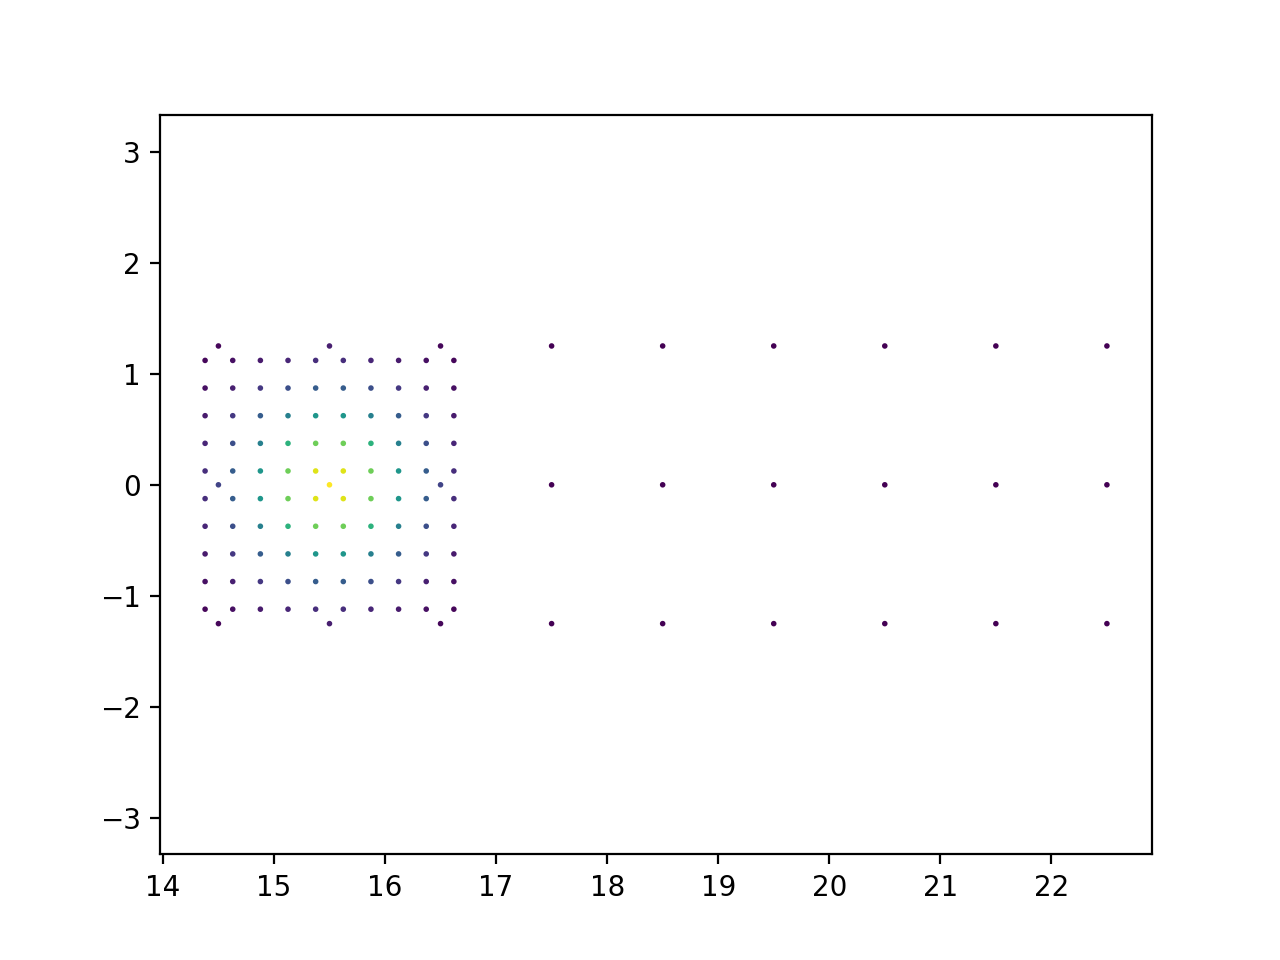

(13.974000120162964, 22.905999994277956, -1.375, 1.375)

In [129]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.scatter(x.detach().cpu().numpy(),
            y.detach().cpu().numpy(),
            c = q.detach().cpu().numpy(),
            s=1)

plt.ylim([-1.25,1.25])
plt.axis('equal')



In [140]:
tt = 3
bc_pts = np.vstack((point_sets[0].detach().cpu().numpy(),
                   point_sets[1].detach().cpu().numpy(),
                   point_sets[2].detach().cpu().numpy(),
                   point_sets[3].detach().cpu().numpy(),
                   point_sets[4].detach().cpu().numpy(),
                   point_sets[5].detach().cpu().numpy()))
bc_pts = bc_pts[bc_pts[:,3]==tt]
domain_pts = point_sets[6].detach().cpu().numpy()
domain_pts = domain_pts[domain_pts[:,3]==tt]

<IPython.core.display.Javascript object>


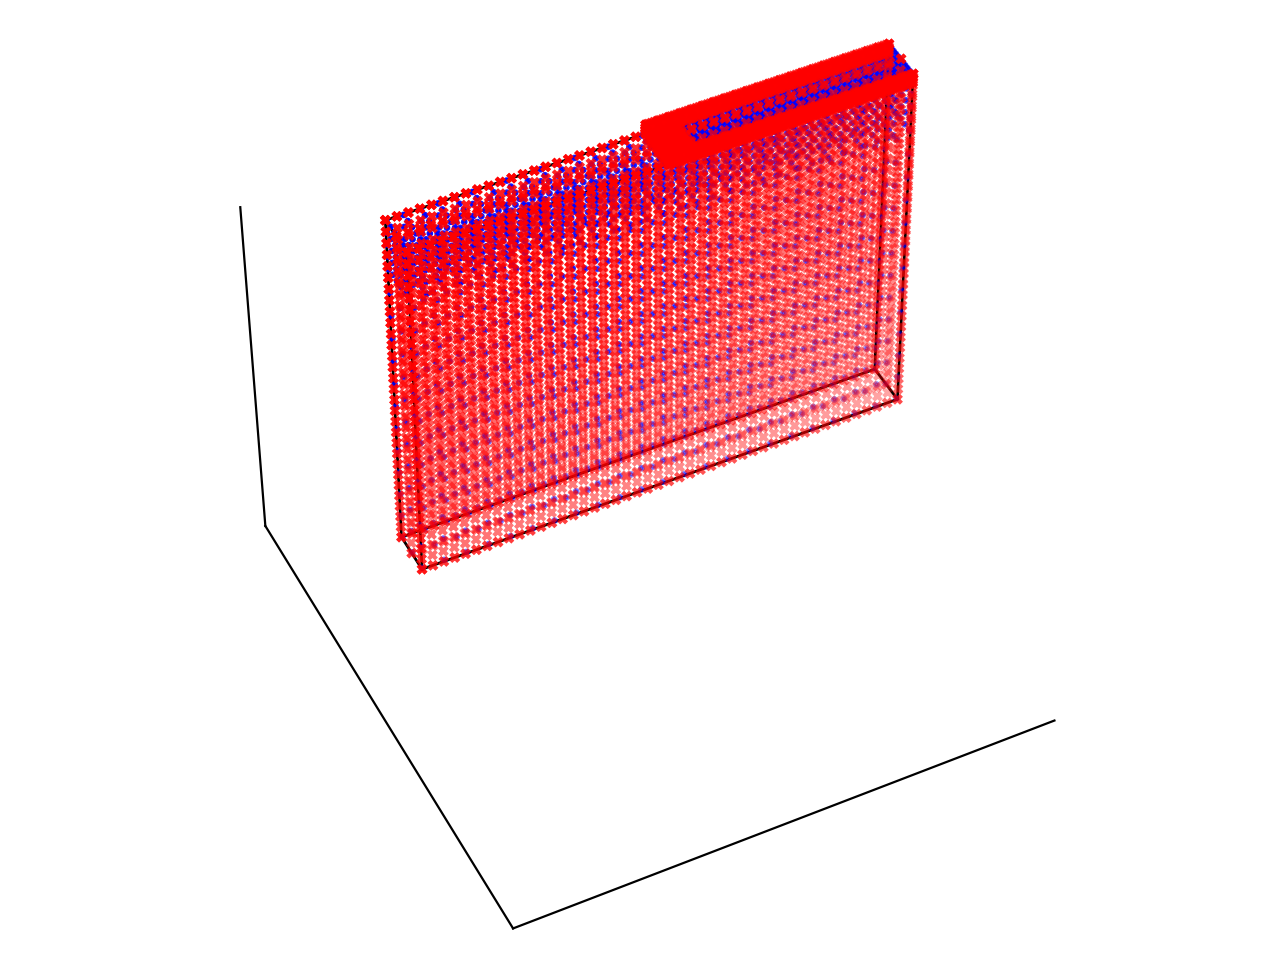

In [142]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
ax = plt.axes(projection='3d')
ax.scatter3D(bc_pts[:,0],bc_pts[:,1],bc_pts[:,2],s=8,marker='x',c='r')
ax.scatter3D(domain_pts[:,0],domain_pts[:,1],domain_pts[:,2],s=8,marker='.',c='b')
ax.plot3D([x_min[0],x_max[0],x_max[0],x_max[0]+v*tt-r,x_max[0]+v*tt-r,x_min[0]     ,x_min[0]],
          [x_min[1],x_min[1],x_min[1],x_min[1]       ,x_min[1]       ,x_min[1]     ,x_min[1]],
          [x_min[2],x_min[2],x_max[2],x_max[2]       ,x_max_prev[2]  ,x_max_prev[2],x_min[2]],'k',lw=1)

ax.plot3D([x_min[0],x_max[0],x_max[0],x_max[0]+v*tt-r,x_max[0]+v*tt-r,x_min[0]     ,x_min[0]],
          [x_max[1],x_max[1],x_max[1],x_max[1]       ,x_max[1]       ,x_max[1]     ,x_max[1]],
          [x_min[2],x_min[2],x_max[2],x_max[2]       ,x_max_prev[2]  ,x_max_prev[2],x_min[2]],'k',lw=1)


ax.plot3D([x_min[0],x_min[0]],
          [x_min[1],x_max[1]],
          [x_min[2],x_min[2]],'k',lw=1)

ax.plot3D([x_max[0],x_max[0]],
          [x_min[1],x_max[1]],
          [x_min[2],x_min[2]],'k',lw=1)

ax.plot3D([x_max[0],x_max[0]],
          [x_min[1],x_max[1]],
          [x_max[2],x_max[2]],'k',lw=1)


ax.plot3D([x_max[0]+v*tt-r,x_max[0]+v*tt-r],
          [x_min[1],x_max[1]],
          [x_max[2],x_max[2]],'k',lw=1)


ax.plot3D([x_max[0]+v*tt-r,x_max[0]+v*tt-r],
          [x_min[1],x_max[1]],
          [x_max_prev[2],x_max_prev[2]],'k',lw=1)

ax.plot3D([x_min[0],x_min[0]],
          [x_min[1],x_max[1]],
          [x_max_prev[2],x_max_prev[2]],'k',lw=1)


ax.set_ylim([-15,15])
ax.set_zlim([-15,15])
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
fig.show()


In [53]:
max(x0+ti*v-2*r,x_min[0])

-14.74

In [54]:

min(x0+ti*v+2*r,x_max[0])

-10.26